In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch  version
torch.__version__

'2.9.0+cu126'

In [2]:
# create "known" parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
# create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing.
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train),len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """plots training data, test data and compares predictions.

    Args:
        train_data (_type_, optional): _description_. Defaults to X_train.
        train_labels (_type_, optional): _description_. Defaults to y_train.
        test_data (_type_, optional): _description_. Defaults to X_test.
        test_labels (_type_, optional): _description_. Defaults to y_test.
        predictions (_type_, optional): _description_. Defaults to None.
    """
    plt.figure(figsize=(20, 7))
    
    # plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    #plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label= "Predictions")
        
        # Show the legend
        plt.legend(prop={"size": 14});
        

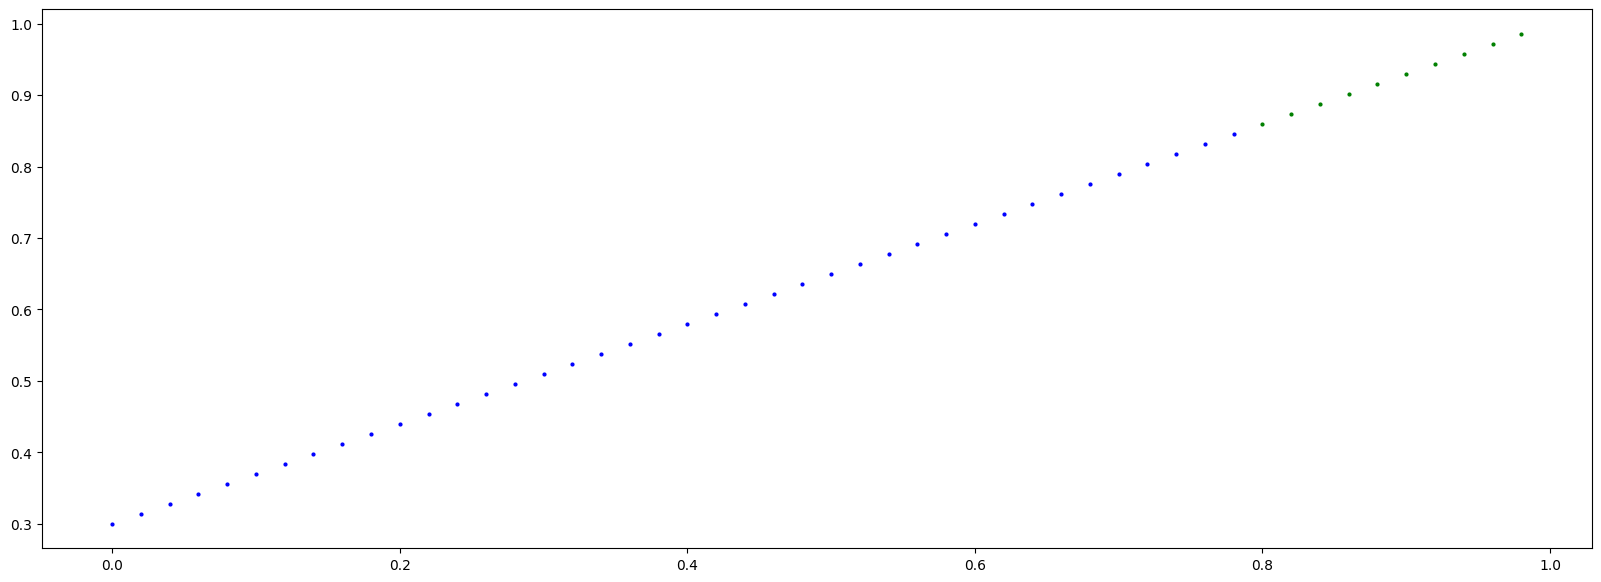

In [5]:
plot_predictions();

**Build Model**

In [6]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in pytorch is a nn.Module(think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,# <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float),# <- PyTorch loves float32 by default
                                    requires_grad=True)# <- can we update this value with gradient descent?)
        self.bias = nn.Parameter(torch.randn(1,# <- start with random bias (this will get adjusted as the model learns)
                                             dtype=torch.float), # <- PyTorch loves float32 by default
                                 requires_grad=True)# <- can we update this value with gradient descent?))
    
    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias  # <- this is the linear regression formula (y = m*x + b)



**Checking the contents of a PyTorch model**

In [7]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)
# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()


# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [9]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [10]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


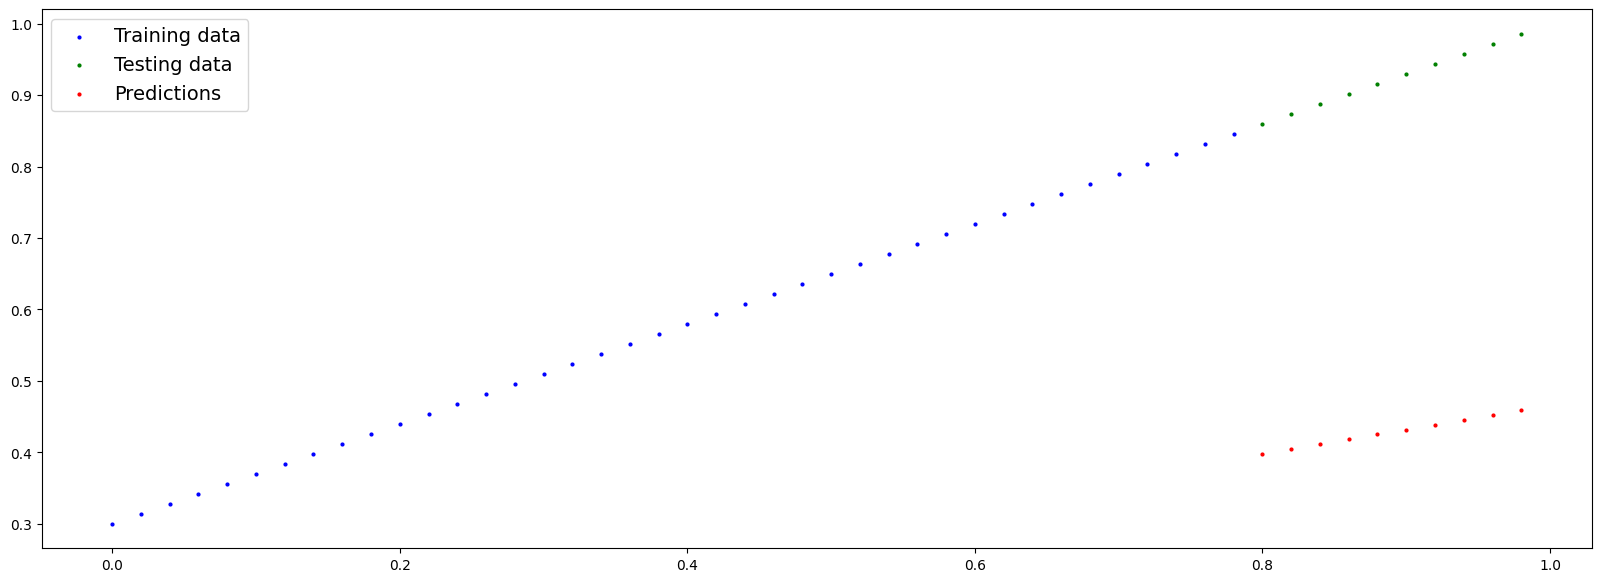

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

**Train model**

In [13]:
# Create the loss function
loss_fn = nn.L1Loss() #MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),# parameters of target model to optimize
                            lr=0.01)# learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))


**Creating an optimization loop in PyTorch**

In [14]:
torch.manual_seed(42)
# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values =[]
epoch_count =[]

for epoch in range(epochs):
    ### Training
    
    # Put model in training mode (this is the default state of a model)
    model_0.train()
    
    #1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    #print(f" Y_PRED: {y_pred}")
    
    #2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)
    #print(F"LOSS FUNCTION: { loss}")
    
    #3. Optimizer zero grad (we need to set the gradients to zero before running the backward pass)
    optimizer.zero_grad()
    
    #4. Backward Loss (backpropagation)
    loss.backward()
    
    #5. Progress the optimizer (update the parameters with gradients and learning rate)
    optimizer.step()
    
    ### Testing
    # Put the model in evaluation mode
    model_0.eval()
    
    with torch.inference_mode():
        #1. Forward pass
        test_pred = model_0(X_test)
        
        #2. Calculate the loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))# predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type
        
         # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")


Epoch: 0 | Train Loss: 0.3129 | Test Loss: 0.4811
Epoch: 10 | Train Loss: 0.1977 | Test Loss: 0.3464
Epoch: 20 | Train Loss: 0.0891 | Test Loss: 0.2173
Epoch: 30 | Train Loss: 0.0531 | Test Loss: 0.1446
Epoch: 40 | Train Loss: 0.0454 | Test Loss: 0.1136
Epoch: 50 | Train Loss: 0.0417 | Test Loss: 0.0992
Epoch: 60 | Train Loss: 0.0382 | Test Loss: 0.0889
Epoch: 70 | Train Loss: 0.0348 | Test Loss: 0.0806
Epoch: 80 | Train Loss: 0.0313 | Test Loss: 0.0723
Epoch: 90 | Train Loss: 0.0279 | Test Loss: 0.0647


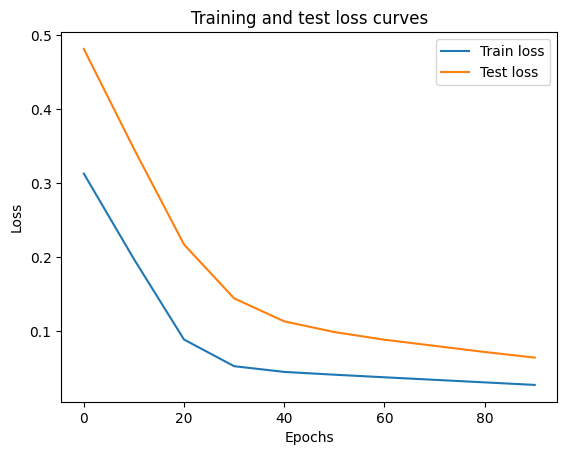

In [15]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [16]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.5784]), 'bias': tensor([0.3513])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [17]:
# 4. Making predictions with a trained PyTorch model(inference)

# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds 

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

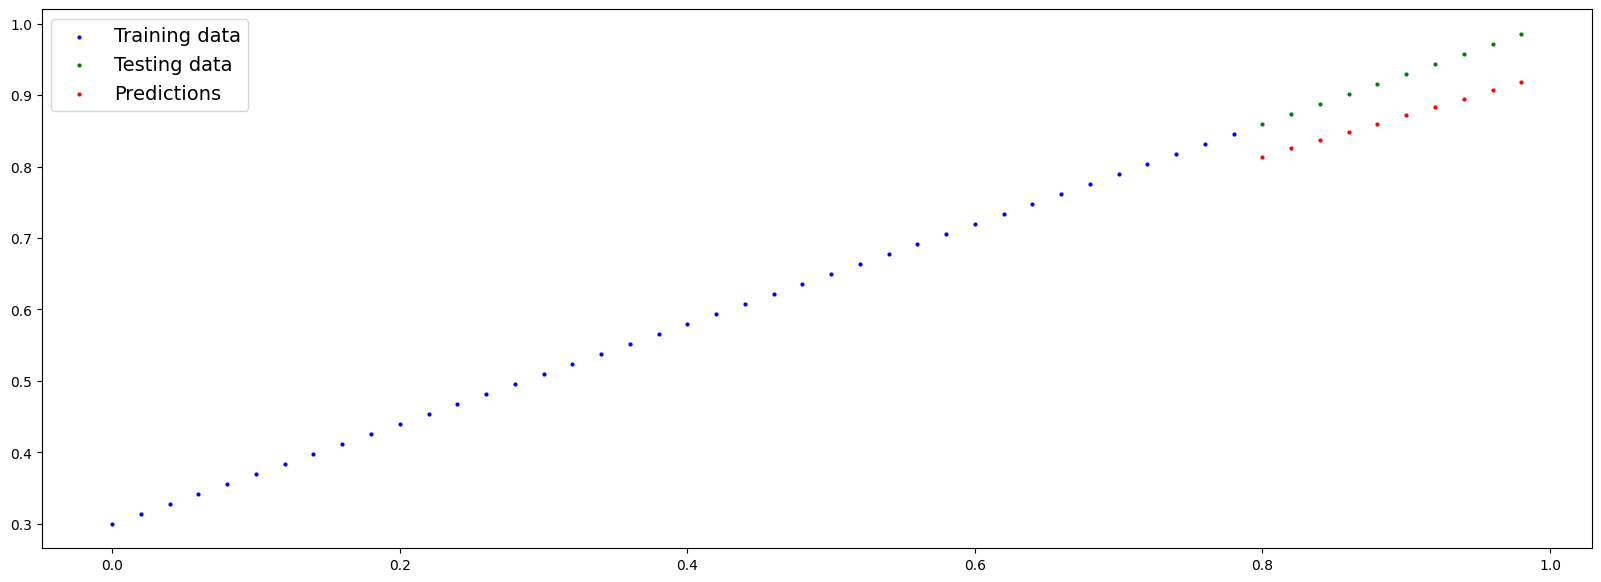

In [18]:
plot_predictions(predictions=y_preds)

**Saving and loading a PyTorch model**

In [19]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_0.pth


In [20]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 2117 Dec 12 08:15 models/01_pytorch_workflow_model_0.pth


**Loading a saved PyTorch model**

In [21]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [22]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [23]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

**Putting it all together**

In [24]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.9.0+cu126'

In [25]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [26]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [27]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)